# Noisy-Clustering

Noise clustering describes a process/algorithm where each noisy data point, is assigned to a noise cluster. The approach also allows you to find "good" clusters among noisy data. The following lines of code will use DBSCAN as an simple clustering-algorithm to extract noisy data points from out datasets. 

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html# 


In [8]:
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
import tensorflow as tf
import tensorflow_hub as tfhub
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

In [9]:
%matplotlib widget

In [10]:
txt_dir = "../datasets/cleaned_datasets/filtered_dataset" 

## Reading Data into DataFrame

In [11]:
def read_data(_dir:str) -> pd.DataFrame:
    data = {}
    data["url"] = []
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.abspath(os.path.join(root, _dir, txt_file))
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                data["url"].append(file_name)
                data["text"].append(txt)
                data["class"].append(class_name)
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [12]:
%%time
df = read_data(txt_dir)

CPU times: user 693 ms, sys: 579 ms, total: 1.27 s
Wall time: 1.29 s


In [13]:
df.head()

,url,text,class
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,an important question that arises while analyz...,prediction
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,in this experiment accuracy of classification ...,prediction
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,also in the context of reproducing trajectorie...,prediction
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,classification is a supervised learning task w...,prediction
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,technical review the context as analyzed above...,prediction


In [14]:
Counter(df["class"])

Counter({'prediction': 2593, 'clustering': 2920, 'pattern_mining': 6361})

## Get the Embeddings

In [15]:
model_url = "./DAN/1fb57c3ffe1a38479233ee9853ddd7a8ac8a8c47/"

In [16]:
%%time
model = tfhub.Module(model_url, trainable=True)

CPU times: user 1.85 s, sys: 165 ms, total: 2.02 s
Wall time: 2.12 s


In [17]:
sess = tf.InteractiveSession()

In [18]:
sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

[None, None]

In [19]:
%%time
embeddings = sess.run(model(list(df["text"])))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 19.7 s, sys: 2.02 s, total: 21.7 s
Wall time: 21 s


In [20]:
sess.close()

In [21]:
print(df.shape)
print(embeddings.shape)

(11874, 3)
(11874, 512)


In [22]:
embeddings[0].reshape(1,-1).shape

(1, 512)

In [23]:
df["embedding"] = [np.squeeze(x.reshape(1,-1)) for x in embeddings]

In [24]:
df.head()

,url,text,class,embedding
0,/Users/Daniel/PycharmProjects/Recommender-Syst...,an important question that arises while analyz...,prediction,"[-0.0019188399, -0.018067172, 0.009413039, 0.0..."
1,/Users/Daniel/PycharmProjects/Recommender-Syst...,in this experiment accuracy of classification ...,prediction,"[-0.045760494, -0.017807078, 0.019112179, -0.0..."
2,/Users/Daniel/PycharmProjects/Recommender-Syst...,also in the context of reproducing trajectorie...,prediction,"[0.017321398, -0.04333527, -0.027918946, -0.04..."
3,/Users/Daniel/PycharmProjects/Recommender-Syst...,classification is a supervised learning task w...,prediction,"[-0.021537159, -0.055107865, -0.036921445, -0...."
4,/Users/Daniel/PycharmProjects/Recommender-Syst...,technical review the context as analyzed above...,prediction,"[0.018828722, -0.041254424, -0.02802634, -0.04..."


## Dimensionality Reduction

### 3 Dimensional PCA

In [25]:
pca = PCA(n_components=3)

In [26]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [27]:
matrix = pca.fit_transform(embeddings_lst)

In [28]:
matrix.shape

(11874, 3)

In [29]:
df["x"] = matrix[:,0]
df["y"] = matrix[:,1]
df["z"] = matrix[:,2]

### 2 Dimensional PCA

In [30]:
pca = PCA(n_components=2)

In [31]:
embeddings_lst = []

for emb in embeddings: 
    embeddings_lst.append(emb)

In [32]:
matrix = pca.fit_transform(embeddings_lst)

In [33]:
df["a"] = matrix[:,0]
df["b"] = matrix[:,1]

In [34]:
#df.head(3)

## Visualization

### Density & Scatter Plot (All Data)

In [45]:
import matplotlib.patches as mpatches


cmaps = cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "purple", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,8))
fig.suptitle("Density & Scatter Plot")

ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)

ax_1.set_title("Density Plot")
ax_2.set_title("Scatter Plot")


labels = []
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = ax_1)
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    ax_2.scatter(group.a, group.b, color = color_from_cmap)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels)


FigureCanvasNbAgg()

### Density and Scatter Plot (Grouped by Class)

In [36]:
#%matplotlib inline
import matplotlib.patches as mpatches


cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "yellow", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(11,9))
#fig.suptitle("Density Plots & Scatter Plots")

ax_1 = fig.add_subplot(2,3,1)
ax_2 = fig.add_subplot(2,3,2)
ax_3 = fig.add_subplot(2,3,3)

ax_4 = fig.add_subplot(2,3,4)
ax_5 = fig.add_subplot(2,3,5)
ax_6 = fig.add_subplot(2,3,6)

labels = []
axis = [ax_1, ax_2, ax_3]
axis_scatter = [ax_4, ax_5, ax_6]
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.a,group.b, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = axis[counter])
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    axis_scatter[counter].scatter(group.a, group.b, color = color_from_cmap, alpha = 0.4)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels, bbox_to_anchor=(2, 1.2))
fig.tight_layout()
fig.savefig("svg/data_description.svg")

FigureCanvasNbAgg()

### 3D Plot all Data

In [37]:
#%matplotlib notebook
#%matplotlib inline
#%matplotlib ipympl

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
fig.suptitle("3D Plot - Second Approach")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

groups = df.groupby("class")
for name, group in groups:
    
    ax.scatter(group.z, group.y, group.x, s = 100, label=name, alpha = 0.1)
   
    ax.legend()
    ax.view_init(azim=70)


FigureCanvasNbAgg()

## Calculate Quality of Clusters

To calculate the Varaiance of an Cluster seems to be a bad idea. Maybe because due to the Softmax-Function (Every data point is in the sum == 1). 
We will use: 
1. __Callinsinski-Harbaz-Index__ --> Measure for better defined Clusters. Higher Score indicates better Clusters
2. __Davies-Bouldin Index__ --> Measure for Seperation between Clusters. Lower Score better Seperation between Clusters

In [38]:
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [39]:
# Create Label Map (Quick and Dirty)
labels = []
for x in df["class"]:
    if x == "clustering":
        labels.append(0)
    elif x == "pattern_mining":
        labels.append(1)
    elif x == "prediction":
        labels.append(2)

In [40]:
df["labels"] = labels

In [49]:
ch_score = calinski_harabaz_score([x for x in df["embedding"].values], df["labels"])
db_score = davies_bouldin_score([x for x in df["embedding"].values], df["labels"])

/anaconda3/envs/rs/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [50]:
ch_score

563.9809864448504

In [51]:
db_score

3.922157551317209

In [65]:
import numpy as np
from scipy.spatial.distance import euclidean, cdist, pdist, squareform

def db_index(X, y):
    """
    Davies-Bouldin index is an internal evaluation method for
    clustering algorithms. Lower values indicate tighter clusters that 
    are better separated.
    """
    # get unique labels
    if y.ndim == 2:
        y = np.argmax(axis=1)
    uniqlbls = np.unique(y)
    n = len(uniqlbls)
    # pre-calculate centroid and sigma
    centroid_arr = np.empty((n, X.shape[1]))
    sigma_arr = np.empty((n,1))
    dbi_arr = np.empty((n,n))
    mask_arr = np.invert(np.eye(n, dtype='bool'))
    for i,k in enumerate(uniqlbls):
        Xk = X[np.where(y==k)[0],...]
        Ak = np.mean(Xk, axis=0)
        centroid_arr[i,...] = Ak
        sigma_arr[i,...] = np.mean(cdist(Xk, Ak.reshape(1,-1)))
    # compute pairwise centroid distances, make diagonal elements non-zero
    centroid_pdist_arr = squareform(pdist(centroid_arr)) + np.eye(n)
    # compute pairwise sigma sums
    sigma_psum_arr = squareform(pdist(sigma_arr, lambda u,v: u+v))
    # divide 
    dbi_arr = np.divide(sigma_psum_arr, centroid_pdist_arr)
    # get mean of max of off-diagonal elements
    dbi_arr = np.where(mask_arr, dbi_arr, 0)
    dbi = np.mean(np.max(dbi_arr, axis=1))
    return dbi

In [72]:
db_index(np.array([x for x in df["embedding"].values]), np.array(df["labels"]))

3.9221576601499244

## Clustering on PCA Data

In [34]:
pd.set_option('display.max_colwidth', 0)

In [35]:
%%time
model_clustering_pca = DBSCAN(eps = 0.095, metric = "euclidean" ,min_samples = 22, n_jobs = -1)
#model_pattern_mining_pca = DBSCAN(eps = 0.15, metric = "euclidean" ,min_samples = 10, n_jobs = -1)
model_pattern_mining_pca = DBSCAN(eps = 0.09, metric = "euclidean" ,min_samples = 30, n_jobs = -1)
#model_prediction_pca = DBSCAN(eps = 0.1, metric = "euclidean" ,min_samples = 30, n_jobs = -1)
model_prediction_pca = DBSCAN(eps = 0.098, metric = "euclidean" ,min_samples = 30, n_jobs = -1)

CPU times: user 27 µs, sys: 3 µs, total: 30 µs
Wall time: 39.1 µs


In [36]:
models_pca = {"clustering":model_clustering_pca,
          "pattern_mining":model_pattern_mining_pca,
          "prediction":model_prediction_pca}

In [37]:
%%time
df_groups_pca = {}
for _class, group in df.groupby("class"): 
    x = group["x"]
    y = group["y"]
    z = group["z"]
    
    points = []
    for point in zip(x,y,z):
        points.append(point)
    
    models_pca[_class].fit(points)
    clusters = Counter(models_pca[_class].labels_)
    print("{}:{}".format(_class,clusters))
    
    _df = pd.DataFrame(group)
    _df["cluster"] = models_pca[_class].labels_
    df_groups_pca[_class] = _df
    

clustering:Counter({0: 2862, -1: 58})
pattern_mining:Counter({0: 6127, -1: 234})
prediction:Counter({0: 2443, -1: 150})
CPU times: user 426 ms, sys: 12 ms, total: 438 ms
Wall time: 379 ms


In [38]:
# Prediction
x = df_groups_pca["clustering"][["class", "text", "cluster"]]
x[x["cluster"] != 0].head(2)

,class,text,cluster
2623,clustering,with this type of qualitative and exploratory research the aim was to understand the relationship between gold label clusters and whether interclustering is or could come to be a competitive advantage at the regional and national level and have an impact on the internal and external economy,-1
2664,clustering,introduction during the past decade unsupervised clustering is wellknown as an effective data mining tool and successfully applied in various tasks such as image segmentation chuang tzeng chen chen hasnat alata trmeau shi malik yin qian gong image categorization liu sun wang liu tao yang nie yan zhuang document categorization mei wang chen miao liu gong and bioinformatics jiang min rao yeung haynor ruzzo etc,-1


In [39]:
# Prediction
x = df_groups_pca["pattern_mining"][["class", "text", "cluster"]]
x[x["cluster"] != 0].head(2)

,class,text,cluster
5630,pattern_mining,in short we employ the association rule mining technique over the mining log to find surrogate patterns representative of frequently used queries in the mining history,-1
5659,pattern_mining,this is because the first element of a sepals expression level means the proportion of the objects that satisfy the exact association rule which is the definition of support of an association rule,-1


In [40]:
# Prediction
x = df_groups_pca["prediction"][["class", "text", "cluster"]]
x[x["cluster"] != 0].head(2)

,class,text,cluster
12,prediction,the twostep approach could not lead to a strong relationship and thus performance of regional prediction is often limited hundecha,-1
23,prediction,financial risk prediction is an important and widely studied topic in the domain of financial analysis since it can help companies to detect financial risks in advance and take appropriate actions to minimize the defaults,-1


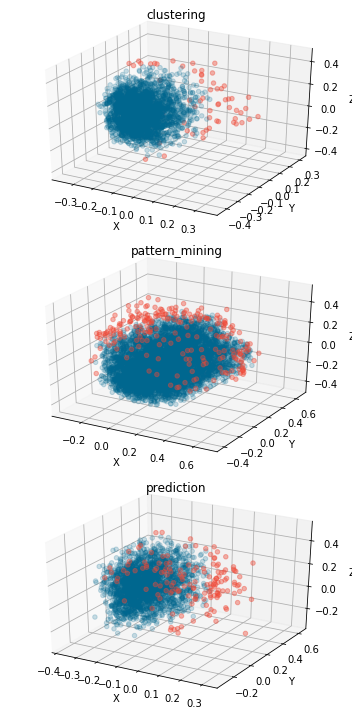

In [41]:
#%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (5,10))
#ax = Axes3D(fig)


for i,_class in enumerate(df_groups_pca.keys()):
    ax = fig.add_subplot(3,1,i+1, projection = "3d")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    
    ax.set_title(_class)
    _df = df_groups_pca[_class]
    for cluster, data in _df.groupby("cluster"):
        if cluster != -1:
            # color_from_cmap = matplotlib.cm.get_cmap("Blues")(random.uniform(0, 1))
            ax.scatter(data.x, data.y, data.z, color = "#00678F", alpha = 0.2)
        else:
            ax.scatter(data.x, data.y, data.z, color = "#EF4836", alpha = 0.4)
fig.tight_layout()
fig.savefig("svg/results_3D.svg")

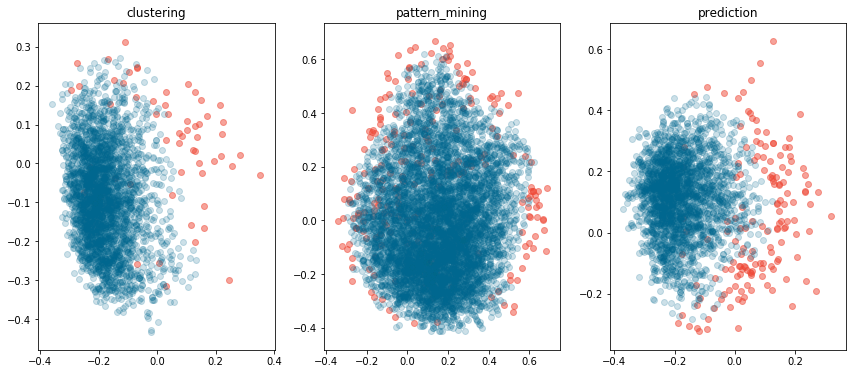

In [42]:
%matplotlib inline

fig = plt.figure(figsize=(12,10))
#fig.suptitle("Scatter Plots")


for i,_class in enumerate(df_groups_pca.keys()):
    ax = fig.add_subplot(2,3,i+1)
    ax.set_title(_class)
    _df = df_groups_pca[_class]
    for cluster, data in _df.groupby("cluster"):
        if cluster != -1:
            color_from_cmap = matplotlib.cm.get_cmap("Blues")(random.uniform(0, 1))
            ax.scatter(data.a, data.b, color = "#00678F", alpha = 0.2)
        else:
            ax.scatter(data.a, data.b, color = "#EF4836", alpha = 0.5)
fig.tight_layout()
fig.savefig("svg/results.svg")

### A Closer Look with FastText and BOW-Average-Method

1. We habe nearly three times more pattern_mining Data so we can discard some. 
2. We should discard those data with less semantic expression
3. First we check the low density areas over b>=2. They should have lower semantic importance
4. Then we check the high density areas around b>=-0.2


Data over 0.2 seem kind of ok, but still a little bit to technical. 

#### Loading FastText

In [43]:
import pickle
ft_model = pickle.load(open("FastText/ft_model_15000.pkl", "rb"))

In [44]:
from nltk.tokenize import word_tokenize
def derive_sentence_vector(sent):
    vectors = []
    sent = word_tokenize(sent)
    for token in sent:
        if ft_model.wv.__contains__(token):
            vectors.append(ft_model.wv.__getitem__(token))
    return sum(vectors)/len(vectors)

#### Appending Vectors to DataFrame

In [45]:
fastText_df = df.drop(columns=['x', 'y', 'z', 'a', 'b'])

In [46]:
vecs = list()
for i, row in df.iterrows():
    vec = derive_sentence_vector(row.text)
    vecs.append(vec)
fastText_df["ft_vec"] = vecs

#### PCA on FastText Data

In [51]:
ft_pca = PCA(n_components=2)
ft_matrix = ft_pca.fit_transform(list(fastText_df["ft_vec"]))
ft_matrix.shape

(11874, 2)

In [52]:
fastText_df["a"] = ft_matrix[:,0]
fastText_df["b"] = ft_matrix[:,1]

In [53]:
ft_pca = PCA(n_components=3)
ft_matrix = ft_pca.fit_transform(list(fastText_df["ft_vec"]))
ft_matrix.shape

(11874, 3)

In [54]:
fastText_df["x"] = ft_matrix[:,0]
fastText_df["y"] = ft_matrix[:,1]
fastText_df["z"] = ft_matrix[:,2]

In [56]:
fastText_df.columns

Index(['url', 'text', 'class', 'embedding', 'ft_vec', 'a', 'b', 'x', 'y', 'z'], dtype='object')

In [57]:
pm_df = fastText_df[fastText_df["class"] == "pattern_mining"]

In [58]:
clustering_df = fastText_df[fastText_df["class"] == "clustering"]


In [59]:
pred_df = fastText_df[fastText_df["class"] == "prediction"]

### Plots

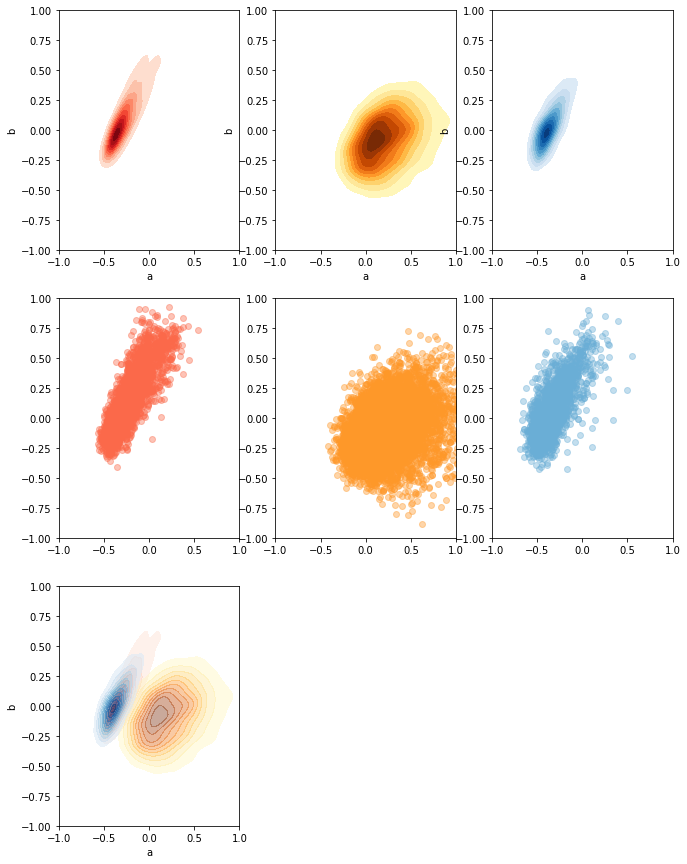

In [60]:
#%matplotlib inline
fig = plt.figure(figsize=(11,15))
#fig.suptitle("Density Plots & Scatter Plots")
cmaps = ["Reds","YlOrBr", "Blues","Greens"]


ax_1 = fig.add_subplot(3,3,1)
ax_2 = fig.add_subplot(3,3,2)
ax_3 = fig.add_subplot(3,3,3)
ax_4 = fig.add_subplot(3,3,4)
ax_5 = fig.add_subplot(3,3,5)
ax_6 = fig.add_subplot(3,3,6)
ax_7 = fig.add_subplot(3,3,7)

sns.kdeplot(clustering_df["a"],clustering_df["b"], shade=True, cmap = "Reds",shade_lowest=False, ax = ax_1)

sns.kdeplot(pm_df["a"],pm_df["b"], shade=True, cmap = "YlOrBr",shade_lowest=False, ax = ax_2)

sns.kdeplot(pred_df["a"],pred_df["b"], shade=True, cmap = "Blues",shade_lowest=False, ax = ax_3)

sns.kdeplot(clustering_df["a"],clustering_df["b"], shade=True, cmap = "Reds",shade_lowest=False, ax = ax_7, alpha=0.4)

sns.kdeplot(pm_df["a"],pm_df["b"], shade=True, cmap = "YlOrBr",shade_lowest=False, ax = ax_7, alpha=0.4)

sns.kdeplot(pred_df["a"],pred_df["b"], shade=True, cmap = "Blues",shade_lowest=False, ax = ax_7, alpha=0.6)


ax_scatter = [ax_4, ax_5, ax_6]
for i, (sc, v) in enumerate(zip(ax_scatter, [clustering_df, pm_df, pred_df])):
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[i])(0.5)
    
    sc.scatter(v.a, v.b, color = color_from_cmap, alpha = 0.4)
    ax_1.set_ylim(bottom=-1, top=1)
    ax_2.set_ylim(bottom=-1, top=1)
    ax_3.set_ylim(bottom=-1, top=1)
    ax_1.set_xlim(left=-1, right=1)
    ax_2.set_xlim(left=-1, right=1)
    ax_3.set_xlim(left=-1, right=1)
    sc.set_ylim(bottom=-1, top=1)
    sc.set_xlim(left=-1, right=1)
    ax_7.set_ylim(bottom=-1, top=1)
    ax_7.set_xlim(left=-1, right=1)

In [114]:
#%matplotlib widget
%matplotlib ipympl

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
fig.suptitle("3D Plot - Second Approach")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

groups = fastText_df.groupby("class")
for name, group in groups:
    
    ax.scatter(group.x, group.y, group.z, s = 100, label=name, alpha = 0.1)
   
    ax.legend()

<IPython.core.display.Javascript object>

This looks indeed much better, less placeholder. I have the feeling the sentences are "saying" more then the above.

## Validating Clusters 

In [108]:
df_export = pd.concat(df_groups_pca)

In [109]:
df_filtered = df_export[df_export["cluster"] != -1]

### Calinski-Harabaz Index

In [110]:
score_new = calinski_harabaz_score([x for x in df_filtered["embedding"].values], df_filtered["class"])
print("Old CH-Index: {}". format(ch_score))
print("New CH-Index: {}". format(score_new))

Old CH-Index: 563.9809864448504
New CH-Index: 583.3658044824474


### Davies-Bouldin Index

In [111]:
score_new = davies_bouldin_score([x for x in df_filtered["embedding"].values], df_filtered["class"])
print("Old DB-Index: {}". format(db_score))
print("New DB-Index: {}". format(score_new))

Old DB-Index: 3.9221575513172007
New DB-Index: 3.7830362124508365


/anaconda3/envs/rs/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


### Saving Data

## Clustering on all Dimension